<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2: Intro to PyTorch

## Deliverable

For this lab, you will submit an ipython notebook via learningsuite.
This lab will be mostly boilerplate code, but you will be required to implement a few extras.

**NOTE: you almost certainly will not understand most of what's going on in this lab!
That's ok - the point is just to get you going with pytorch.
We'll be working on developing a deeper understanding of every part of this code
over the course of the next two weeks.**

A major goal of this lab is to help you become conversant in working through pytorch
tutorials and documentation.
So, you should feel free to google whatever you want and need!

This notebook will have four parts:

* Part 1: Your notebook should contain the boilerplate code. See below.

* Part 2: Your notebook should extend the boilerplate code by adding a testing loop.

* Part 3: Your notebook should extend the boilerplate code by adding a visualization of test/training performance over time.

The resulting image could, for example, look like this:
![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?cache=&w=900&h=608&tok=3092fe&media=cs501r_f2018:lab2.png)

* Part 4: Your notebook should contain the completed microtasks and pass all the asserts.

See the assigned readings for pointers to documentation on pytorch.
___

### Grading standards:
Your notebook will be graded on the following:

* 40% Successfully followed lab video and typed in code
* 20% Modified code to include a test/train split
* 20% Modified code to include a visualization of train/test losses
* 10% Tidy and legible figures, including labeled axes where appropriate
* 10% Correct solutions to the microtasks
___

### Description
Throughout this class, we will be using pytorch to implement our deep neural networks. 
Pytorch is a deep learning framework that handles the low-level details of 
GPU integration and automatic differentiation.

The goal of this lab is to help you become familiar with pytorch. 
The four parts of the lab are outlined above.

For part 1, you should watch the video below, and type in the code as it is explained to you.

A more detailed outline of Part 1 is below.

For part 2, you must add a validation (or testing) loop using the 
FashionMNIST dataset with train=False

For part 3, you must plot the loss values.

For part 4, you must complete the microtasks and pass all asserts.

Optional: Demonstrate overfitting on the training data.

The easiest way to do this is to limit the size of your training dataset 
so that it only returns a single batch (ie len(dataloader) == batch_size, 
and train for multiple epochs. For example,
I set my batch size to 42, and augmented my dataloader to produce only 42 
unique items by overwriting the len function to return 42. 
In my training loop, I performed a validation every epoch which basically corresponded 
to a validation every step.

In practice, you will normally compute your validation loss every n steps, 
rather than at the end of every epoch. This is because some epochs can take hours, 
or even days and you don’t often want to wait that long to see your results.

Testing your algorithm by using a single batch and training until overfitting 
is a great way of making sure that your model and optimizer are working the way they should!

___

### Part 0
[Watch Tutorial Video here](https://www.youtube.com/watch?v=E76hLX9WCLE)

**TODO:**

**DONE:**
* Watch video
___

### Part 1
Your notebook should contain the boilerplate code. See below.

**TODO:**

**DONE:**
* Replicate boilerplate from the video
___

### Part 2
Your notebook should extend the boilerplate code by adding a testing loop.

**TODO:**

**DONE:**
* Add a testing (validation) loop

In [1]:
!pip3 install torch 
!pip3 install torchvision
!pip3 install tqdm

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
 
assert torch.cuda.is_available() # You need to request a GPU from Runtime > Change Runtime Type

# Define classes that extend PyTorch classes
# Network class
class LinearNetwork(nn.Module):
    def __init__(self, dataset):
        super(LinearNetwork, self).__init__()
        x, y = dataset[0]
        print(y, type(y))
        c, h, w = x.size() # channel, height, width of image
        out = 10
        layer1_dim = 1000

        self.net = nn.Sequential(nn.Linear(c * h * w, layer1_dim),
                                 nn.ReLU(),
                                 nn.Linear(layer1_dim, out))

    def forward(self, x):
        n, c, h, w = x.size() # n = batch size
        flattened = x.view(n, c * h * w)
        return self.net(flattened)

# Dataset class
class FashionMNISTProcessedDataset(Dataset):
    def __init__(self, root, train=True):
        self.data = datasets.FashionMNIST(root, 
                                          train=train, 
                                          transform=transforms.ToTensor(),
                                          download=True)

    def __getitem__(self, idx):
        x, y = self.data[idx]
        return x, y

    def __len__(self):
        return len(self.data)

In [2]:
# Instantiate the train and validation sets
train_dataset = FashionMNISTProcessedDataset('/tmp/fashionmnist', train=True)
val_dataset = FashionMNISTProcessedDataset('/tmp/fashionmnist', train=False)

# Instantiate your data loaders
train_loader = DataLoader(train_dataset, # You can change the way batches are shuffled here
                          batch_size=42, # Multiple threads
                          pin_memory=True) # Speed improvement param, use same block of GPU memory
val_loader = DataLoader(val_dataset, batch_size=42)

In [3]:
# Instantiate your model
model = LinearNetwork(train_dataset)
model = model.cuda() # Move to GPU memory

# Instantiate loss and optimizer functions
loss_func = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-4)

9 <class 'int'>


In [34]:
# Training and validation loops
train_losses = []
val_losses = []
num_epochs = 200

loop = tqdm(total=len(train_loader) * num_epochs, position=0) # Gives an idea of how long training will take

cntr = 0
for epoch in range(num_epochs):

    batch = 0
    for x, y_truth in train_loader:
        x, y_truth = x.cuda(non_blocking=True), y_truth.cuda(non_blocking=True) # non_blocking is speed up (async)
        
        optimizer.zero_grad() # Set gradient to zero

        y_hat = model(x)
        loss = loss_func(y_hat, y_truth) # Both params need to be floats
        
        # Check the validation for first 25 epochs of first batch
        if epoch % 25 == 0 and batch == 0:
            train_losses.append(loss)

            val_loss_list = []
            for val_x, val_y in val_loader:
                 val_x, val_y = val_x.cuda(non_blocking=True), val_y.cuda(non_blocking=True)
                 val_y_hat = model(val_x)
                 val_loss_list.append(loss_func(val_y_hat, val_y))

            val_losses.append(sum(val_loss_list) / float(len(val_loss_list)))

            cntr += 1

        loop.set_description('loss: {:.4f}'.format(loss.item()))
        loop.update(1)

        loss.backward() # Compute gradient, for weight with respect to loss
        optimizer.step() # Take step in the direction of the negative gradient
        batch += 1

loop.close()

loss: 0.5017: 100%|██████████| 285800/285800 [29:06<00:00, 163.61it/s]



___

### Part 3
Your notebook should extend the boilerplate code by adding a visualization of test/training
performance over time. Use matplotlib.pyplot

**TODO:**

**DONE:**

* Add a visualization of test/train performance (i.e. loss) over time.


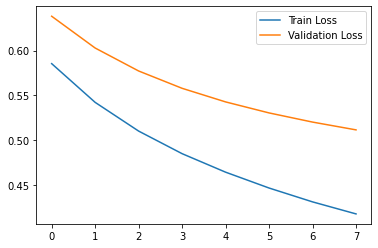

In [39]:
fig = plt.figure()

ax = fig.add_subplot(111)
ax.plot(range(len(train_losses)), train_losses, label="Train Loss")
ax.plot(range(len(val_losses)), val_losses, label="Validation Loss")
plt.legend()
plt.show()


___

### Part 4
Complete the following microtasks to learn some important Pytorch skills. 

**TODO:**

**DONE:**
* Complete microtasks

In [15]:
# Tensors are the the lifeblood of Pytorch. 
# Construct a 5x3 tensor, 'a', of zeros and of dtype long
a = torch.empty(5,3, dtype=torch.long)
print(a)
print(a.size())
assert a.size() == torch.Size([5, 3])
assert type(a[0][0].item()) is int

tensor([[  3105572992, 206158430258, 206158430253],
        [193273528377, 214748364849, 210453397588],
        [249108103223, 210453397557, 219043332154],
        [197568495672, 231928234035, 219043332151],
        [231928234033, 450971566170, 433791696995]])
torch.Size([5, 3])


In [16]:
# Many of your bugs will come from incorrect tensor dimensions. 
# Pytorch has several built-in functions to give you the control need. 
# Using only the .unsqueeze() function, turn 'a' into a 5x1x3 tensor. Hint: use the dim= argument
a = a.unsqueeze(dim=1)
print(a.shape)
assert a.shape == torch.Size([5, 1, 3])

torch.Size([5, 1, 3])


In [17]:
# Each dimension means something different. 
# You can change the order of your dimensions without losing information. 
# Reshape 'a' into a 5x3x1 tensor, using the .view() function
a = a.view(5,3,1)
print(a.shape)
assert a.shape == torch.Size([5, 3, 1])

torch.Size([5, 3, 1])


In [18]:
# Dimensions of size 1 can sometimes be necessary for shape matching.
# However, they can be removed without losing information. 
# Squeeze 'a' to remove dimensions of 1
a = a.squeeze()
print(a.shape)
assert a.size() == torch.Size([5, 3])

torch.Size([5, 3])


In [19]:
# You can turn any tensor into a tensor of a single dimension. 
# Flatten 'a' to a single dimension
a = a.flatten()
print(a.size())
assert  a.size() == torch.Size([15]) 

torch.Size([15])


In [20]:
# It's easy to integrate other common python data structures. 
# Initialize a tensor, 'b', from a list
my_list = [1,2,3,4,5]
b = torch.tensor(my_list)
print(b)
assert b.size() == torch.Size([5])

tensor([1, 2, 3, 4, 5])


In [30]:
# GPUs will allow tensor operations to run much faster. 
# Assign 'a' and 'b' to run on GPU
gpu_device = torch.device("cuda")
a = a.to(device=gpu_device)
b = b.to(device=gpu_device)
print(a, b)
assert a.is_cuda and b.is_cuda

tensor([  3105572992, 206158430258, 206158430253, 193273528377, 214748364849,
        210453397588, 249108103223, 210453397557, 219043332154, 197568495672,
        231928234035, 219043332151, 231928234033, 450971566170, 433791696995],
       device='cuda:0') tensor([1, 2, 3, 4, 5], device='cuda:0')


In [31]:
# You might not always have access to a GPU
# Assign 'a' and 'b' to run on CPU
cpu_device = torch.device("cpu")
a = a.to(device=cpu_device)
b = b.to(device=cpu_device)
print(a, b)
assert not a.is_cuda and not b.is_cuda

tensor([  3105572992, 206158430258, 206158430253, 193273528377, 214748364849,
        210453397588, 249108103223, 210453397557, 219043332154, 197568495672,
        231928234035, 219043332151, 231928234033, 450971566170, 433791696995]) tensor([1, 2, 3, 4, 5])


In [32]:
# You will often want to convert tensors to numpy arrays to interact with other python libraries
# Convert 'a' to a numpy array 'c'
c = a.numpy()
print(type(c))
assert type(c) == np.ndarray

<class 'numpy.ndarray'>


In [33]:
# To get your data back into Pytorch
# Convert 'c' to tensor 'd'
d = torch.from_numpy(c,)
print(d.type())
assert torch.is_tensor(d)

torch.LongTensor
